# KALM Helm Chart Security Analysis

This notebook provides comprehensive security analysis for Helm charts using the KALM benchmark suite, including:

- **Chart-specific security assessment** with per-chart vulnerability analysis
- **Scanner comparison** across helm deployments vs traditional manifests
- **Deployment pattern analysis** identifying common security issues in helm charts
- **Severity distribution** and risk prioritization for helm-based workloads
- **Historical trends** in helm chart security posture

**Goal**: Enable data-driven security decisions for helm chart deployments and identify the most effective scanning strategies for kubernetes helm-based infrastructure.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path
import warnings
from datetime import datetime, timedelta

# KALM imports
from kalm_benchmark.evaluation.evaluation import load_benchmark, Col
from kalm_benchmark.evaluation.helm_security_service import HelmSecurityService
from kalm_benchmark.ui.analytics.helm_analytics import get_helm_chart_popularity_metrics
from kalm_benchmark.ui.interface.source_filter import extract_helm_chart_name
from kalm_benchmark.utils.helm_utils import normalize_helm_chart_results

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("Set2")

print("🎡 KALM Helm Chart Security Analysis - Initializing...")

## 1. Data Loading and Helm Chart Discovery

Load scanner results and identify helm chart deployments for security analysis.

In [9]:
# Load database and helm chart results
db_path = Path('../data/kalm.db')

if not db_path.exists():
    print("❌ Database not found. Run helm chart scans first using: poetry run cli scan <scanner> -f helm-charts")
    df_helm = pd.DataFrame()  # Empty dataframe for demo
else:
    with sqlite3.connect(db_path) as conn:
        # Load helm chart specific results
        df_helm = pd.read_sql_query("""
            SELECT 
                scanner_name,
                scanner_check_id,
                scanner_check_name,
                obj_name,
                kind,
                namespace,
                severity,
                got as status,
                scan_timestamp,
                source_file,
                created_at
            FROM scanner_results 
            WHERE source_file LIKE 'helm-chart:%'
            ORDER BY created_at DESC, scanner_name
        """, conn)
        
        if len(df_helm) > 0:
            # Extract chart names and normalize data
            df_helm['chart_name'] = df_helm['source_file'].apply(extract_helm_chart_name)
            df_helm['scan_date'] = pd.to_datetime(df_helm['scan_timestamp']).dt.date
            
            print(f"📊 Loaded {len(df_helm):,} helm chart security results")
            print(f"📊 Charts analyzed: {df_helm['chart_name'].nunique()}")
            print(f"📊 Scanners used: {df_helm['scanner_name'].nunique()}")
            print(f"📊 Date range: {df_helm['scan_date'].min()} to {df_helm['scan_date'].max()}")
            
            # Show top charts by findings
            chart_summary = df_helm.groupby('chart_name').agg({
                'scanner_name': 'nunique',
                'severity': lambda x: x.notna().sum(),
                'obj_name': 'count',
                'scan_date': ['min', 'max']
            })
            chart_summary.columns = ['scanners_used', 'with_severity', 'total_findings', 'first_scan', 'latest_scan']
            chart_summary = chart_summary.sort_values('total_findings', ascending=False)
            
            print("\n📊 Top Charts by Security Findings:")
            for chart, row in chart_summary.head(10).iterrows():
                print(f"   {chart}: {row['total_findings']} findings ({row['scanners_used']} scanners, {row['with_severity']} with severity)")
        else:
            print("⚠️  No helm chart results found. Run: poetry run cli scan <scanner> -f helm-charts")

📊 Loaded 491 helm chart security results
📊 Charts analyzed: 3
📊 Scanners used: 3
📊 Date range: 2025-08-31 to 2025-09-02

📊 Top Charts by Security Findings:
   kube-prometheus-stack: 192 findings (3 scanners, 107 with severity)
   cert-manager: 168 findings (3 scanners, 95 with severity)
   ingress-nginx: 131 findings (3 scanners, 79 with severity)


## 2. Helm Chart Security Overview

Analyze the overall security posture of helm chart deployments.

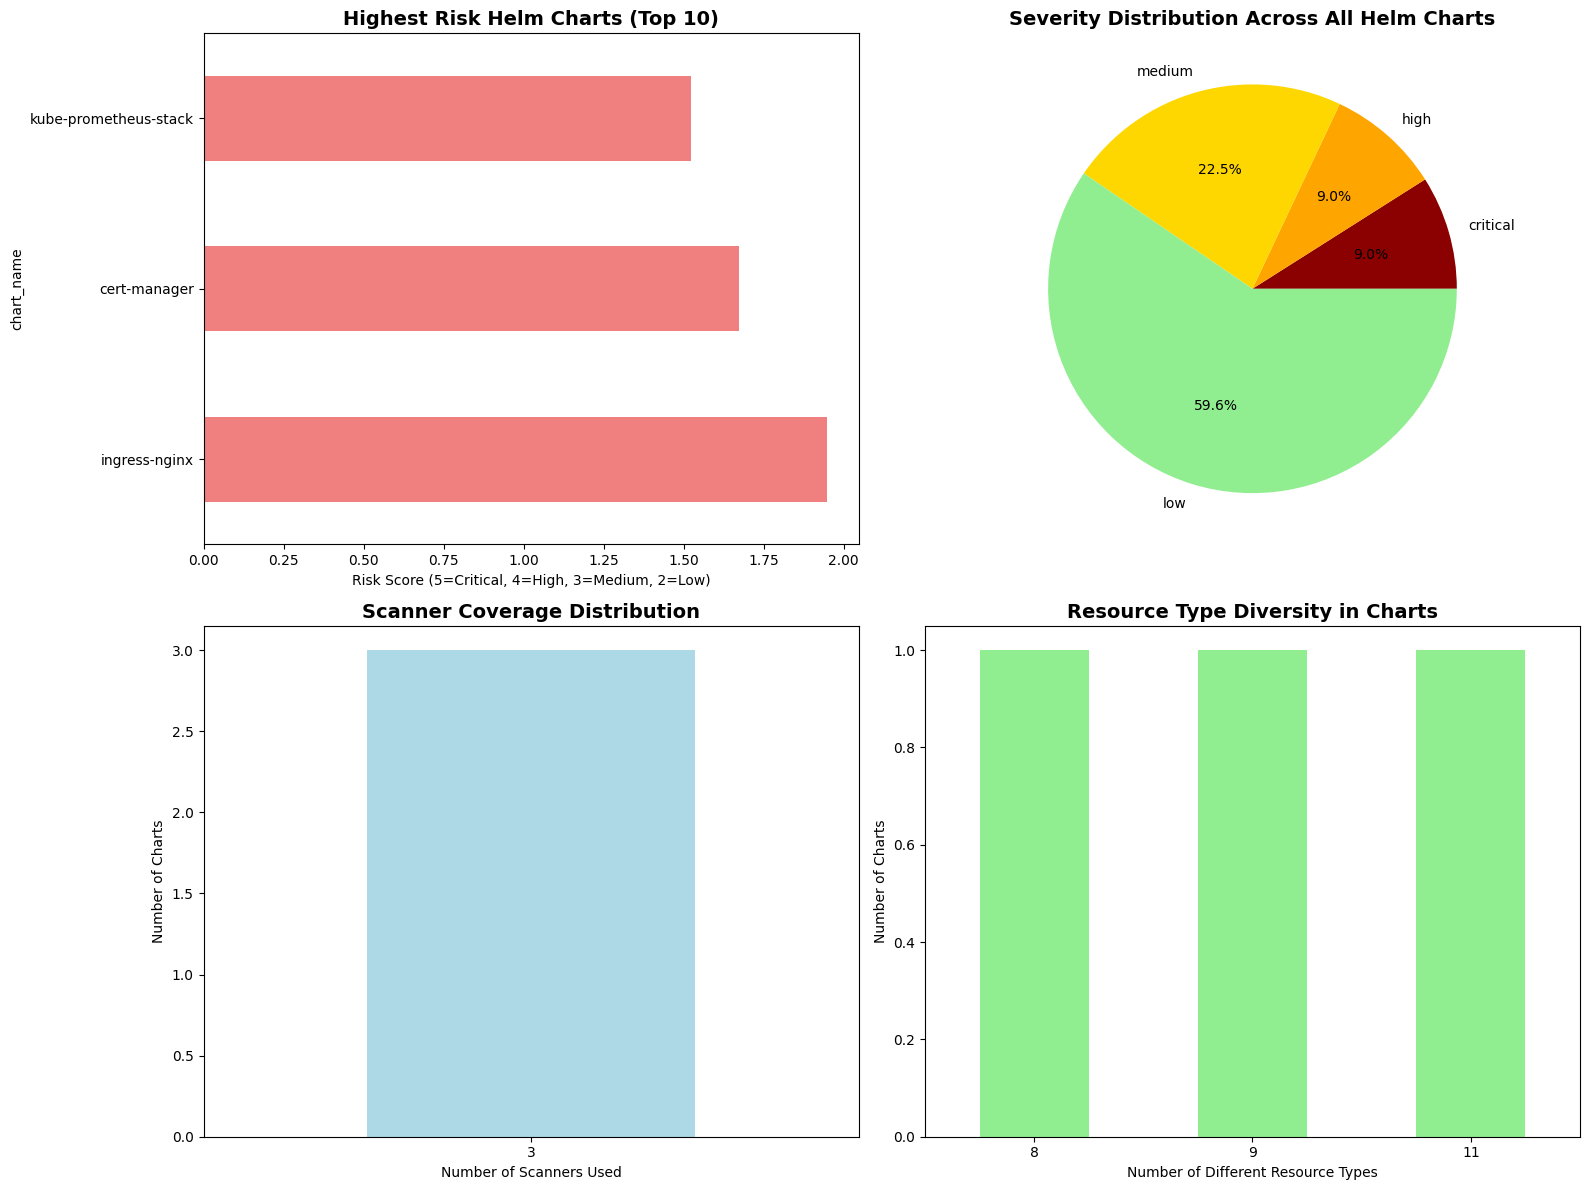


📊 Security Summary:
   Average risk score: 1.72
   Charts with critical issues: 3
   Charts with high+ severity: 3
   Average scanner coverage: 3.0 scanners per chart


In [10]:
if len(df_helm) > 0:
    # Security overview by chart
    security_overview = df_helm.groupby('chart_name').agg({
        'severity': ['count', lambda x: x.notna().sum(), lambda x: (x == 'CRITICAL').sum(), 
                    lambda x: (x == 'HIGH').sum(), lambda x: (x == 'MEDIUM').sum(), 
                    lambda x: (x == 'LOW').sum()],
        'scanner_name': 'nunique',
        'kind': lambda x: x.nunique()
    })
    
    security_overview.columns = ['total_findings', 'with_severity', 'critical', 'high', 
                                'medium', 'low', 'scanners', 'resource_types']
    
    # Calculate risk scores (weighted by severity)
    security_overview['risk_score'] = (
        security_overview['critical'] * 5 + 
        security_overview['high'] * 4 + 
        security_overview['medium'] * 3 + 
        security_overview['low'] * 2
    ) / security_overview['total_findings']
    
    security_overview = security_overview.sort_values('risk_score', ascending=False)
    
    # Visualize security overview
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Chart risk scores
    top_risky_charts = security_overview.head(10)
    top_risky_charts['risk_score'].plot(kind='barh', ax=ax1, color='lightcoral')
    ax1.set_title('Highest Risk Helm Charts (Top 10)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Risk Score (5=Critical, 4=High, 3=Medium, 2=Low)')
    
    # Severity distribution across all charts
    severity_totals = security_overview[['critical', 'high', 'medium', 'low']].sum()
    severity_totals.plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                        colors=['darkred', 'orange', 'gold', 'lightgreen'])
    ax2.set_title('Severity Distribution Across All Helm Charts', fontsize=14, fontweight='bold')
    ax2.set_ylabel('')
    
    # Scanner coverage by chart
    scanner_coverage = security_overview['scanners'].value_counts().sort_index()
    scanner_coverage.plot(kind='bar', ax=ax3, color='lightblue')
    ax3.set_title('Scanner Coverage Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Number of Scanners Used')
    ax3.set_ylabel('Number of Charts')
    ax3.tick_params(axis='x', rotation=0)
    
    # Resource type diversity
    resource_diversity = security_overview['resource_types'].value_counts().sort_index()
    resource_diversity.plot(kind='bar', ax=ax4, color='lightgreen')
    ax4.set_title('Resource Type Diversity in Charts', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Number of Different Resource Types')
    ax4.set_ylabel('Number of Charts')
    ax4.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Security Summary:")
    print(f"   Average risk score: {security_overview['risk_score'].mean():.2f}")
    print(f"   Charts with critical issues: {(security_overview['critical'] > 0).sum()}")
    print(f"   Charts with high+ severity: {((security_overview['critical'] + security_overview['high']) > 0).sum()}")
    print(f"   Average scanner coverage: {security_overview['scanners'].mean():.1f} scanners per chart")
else:
    print("⚠️  No helm chart data available for security overview")

## 3. Scanner Performance Comparison for Helm Charts

Compare how different security scanners perform specifically on helm chart deployments.

📊 Scanner Performance on Helm Charts:
   checkov: 210 findings across 3 charts (0.0% with severity, 70.0 findings/chart)
   trivy: 178 findings across 3 charts (100.0% with severity, 59.3 findings/chart)
   snyk: 103 findings across 3 charts (100.0% with severity, 34.3 findings/chart)


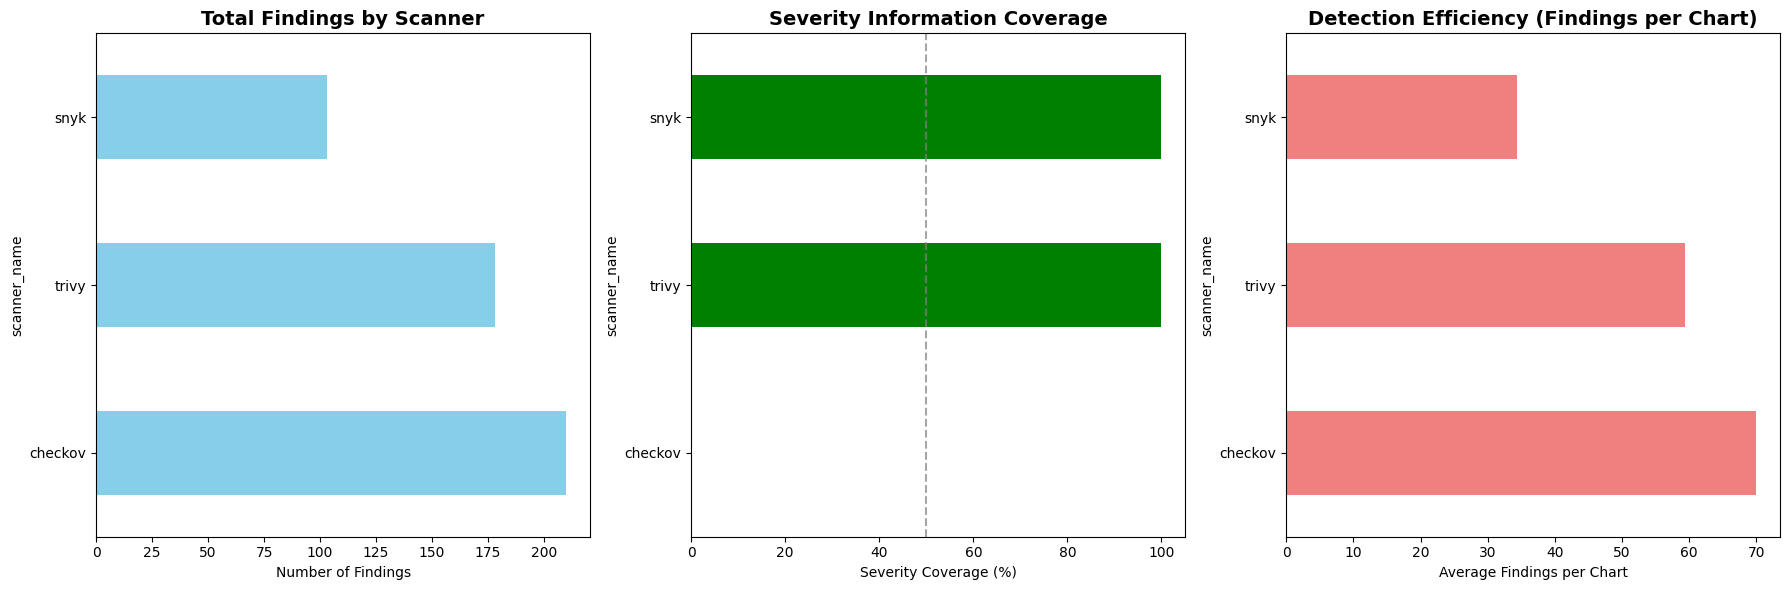


🎯 Scanner Effectiveness for Helm Charts:
   trivy: 91.0/100 (findings: 85, coverage: 100, efficiency: 85)
   snyk: 69.4/100 (findings: 49, coverage: 100, efficiency: 49)
   checkov: 60.0/100 (findings: 100, coverage: 0, efficiency: 100)


In [11]:
if len(df_helm) > 0:
    # Scanner performance analysis
    scanner_performance = df_helm.groupby('scanner_name').agg({
        'chart_name': 'nunique',
        'obj_name': 'count',
        'severity': ['count', lambda x: x.notna().sum()],
        'kind': lambda x: x.nunique()
    })
    
    scanner_performance.columns = ['charts_scanned', 'total_findings', 'findings_with_severity', 
                                  'with_severity_count', 'resource_types_detected']
    
    # Calculate metrics
    scanner_performance['severity_coverage_pct'] = (
        scanner_performance['with_severity_count'] / scanner_performance['total_findings'] * 100
    ).round(1)
    
    scanner_performance['findings_per_chart'] = (
        scanner_performance['total_findings'] / scanner_performance['charts_scanned']
    ).round(1)
    
    scanner_performance = scanner_performance.sort_values('total_findings', ascending=False)
    
    print("📊 Scanner Performance on Helm Charts:")
    for scanner, row in scanner_performance.iterrows():
        charts = int(row['charts_scanned'])
        findings = int(row['total_findings'])
        severity_pct = row['severity_coverage_pct']
        per_chart = row['findings_per_chart']
        print(f"   {scanner}: {findings} findings across {charts} charts ({severity_pct}% with severity, {per_chart} findings/chart)")
    
    # Visualize scanner comparison
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Total findings by scanner
    scanner_performance['total_findings'].plot(kind='barh', ax=ax1, color='skyblue')
    ax1.set_title('Total Findings by Scanner', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Findings')
    
    # Severity coverage percentage
    severity_colors = ['green' if x >= 80 else 'orange' if x >= 50 else 'red' 
                      for x in scanner_performance['severity_coverage_pct']]
    scanner_performance['severity_coverage_pct'].plot(kind='barh', ax=ax2, color=severity_colors)
    ax2.set_title('Severity Information Coverage', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Severity Coverage (%)')
    ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.7)
    
    # Findings per chart efficiency
    scanner_performance['findings_per_chart'].plot(kind='barh', ax=ax3, color='lightcoral')
    ax3.set_title('Detection Efficiency (Findings per Chart)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Average Findings per Chart')
    
    plt.tight_layout()
    plt.show()
    
    # Scanner effectiveness matrix
    print("\n🎯 Scanner Effectiveness for Helm Charts:")
    effectiveness = scanner_performance[['total_findings', 'severity_coverage_pct', 'findings_per_chart']].copy()
    
    # Normalize metrics to 0-100 scale for comparison
    effectiveness['findings_score'] = (effectiveness['total_findings'] / effectiveness['total_findings'].max() * 100).round(0)
    effectiveness['coverage_score'] = effectiveness['severity_coverage_pct']
    effectiveness['efficiency_score'] = (effectiveness['findings_per_chart'] / effectiveness['findings_per_chart'].max() * 100).round(0)
    
    effectiveness['overall_score'] = (
        effectiveness['findings_score'] * 0.4 + 
        effectiveness['coverage_score'] * 0.4 + 
        effectiveness['efficiency_score'] * 0.2
    ).round(1)
    
    effectiveness_sorted = effectiveness.sort_values('overall_score', ascending=False)
    for scanner, row in effectiveness_sorted.iterrows():
        overall = row['overall_score']
        findings = int(row['findings_score'])
        coverage = int(row['coverage_score'])
        efficiency = int(row['efficiency_score'])
        print(f"   {scanner}: {overall}/100 (findings: {findings}, coverage: {coverage}, efficiency: {efficiency})")
else:
    print("⚠️  No helm chart data available for scanner comparison")

## 4. Chart-Specific Security Patterns

Identify common security issues and patterns across different helm charts.

📊 Most Common Security Issues Across Helm Charts:
   (Showing issues affecting 2+ charts)

   The default namespace should not be used (ConfigMap): 3 charts, 33 instances, severity: UNKNOWN
   The default namespace should not be used (ServiceAccount): 3 charts, 14 instances, severity: UNKNOWN
   Role or ClusterRole with dangerous permissions (ClusterRole): 3 charts, 11 instances, severity: high
   The default namespace should not be used (Service): 3 charts, 11 instances, severity: UNKNOWN
   Container could be running with outdated image (Deployment): 3 charts, 9 instances, severity: low
   Container has no CPU limit (Deployment): 3 charts, 9 instances, severity: low
   Container is running without memory limit (Deployment): 3 charts, 9 instances, severity: low
   Role that grant permissions to system reserved namespace (RoleBinding): 3 charts, 9 instances, severity: medium
   CPU limits should be set (Deployment): 3 charts, 7 instances, severity: UNKNOWN
   Container's or Pod's  UID 

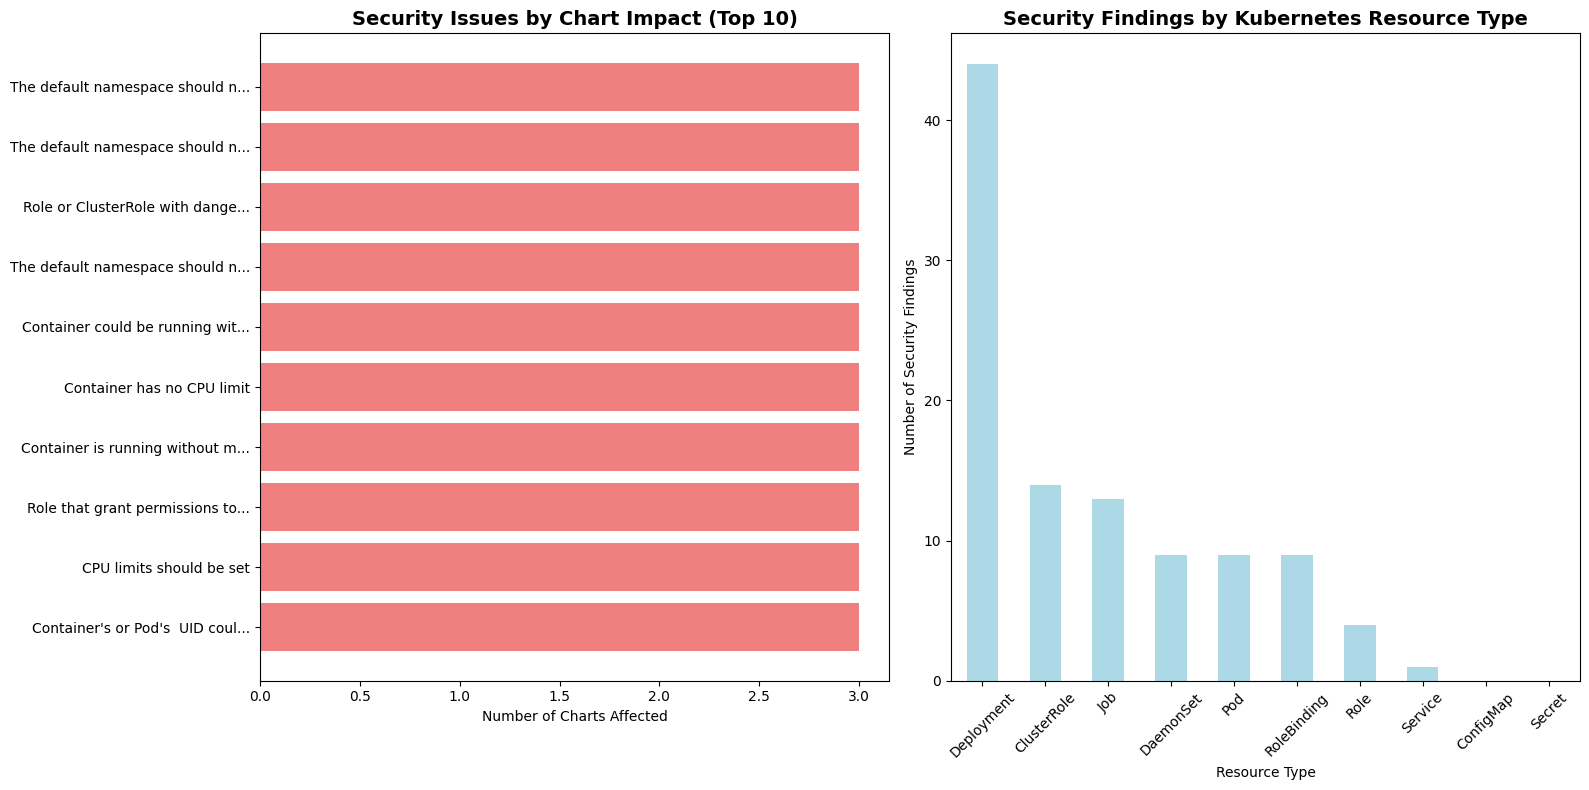


🎯 Security Pattern Analysis:
   Charts with similar security profiles:
     cert-manager ↔ kube-prometheus-stack (correlation: 0.90)
     cert-manager ↔ ingress-nginx (correlation: 0.89)
     ingress-nginx ↔ kube-prometheus-stack (correlation: 0.88)


In [12]:
if len(df_helm) > 0:
    # Analyze security patterns by resource type and check
    pattern_analysis = df_helm.groupby(['scanner_check_name', 'kind']).agg({
        'chart_name': 'nunique',
        'obj_name': 'count',
        'severity': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'UNKNOWN'
    }).rename(columns={'chart_name': 'charts_affected', 'obj_name': 'total_instances', 'severity': 'common_severity'})
    
    # Focus on issues affecting multiple charts
    widespread_issues = pattern_analysis[pattern_analysis['charts_affected'] >= 2].sort_values(
        ['charts_affected', 'total_instances'], ascending=[False, False]
    )
    
    print("📊 Most Common Security Issues Across Helm Charts:")
    print("   (Showing issues affecting 2+ charts)\n")
    
    for (check, kind), row in widespread_issues.head(15).iterrows():
        charts = int(row['charts_affected'])
        instances = int(row['total_instances'])
        severity = row['common_severity']
        print(f"   {check} ({kind}): {charts} charts, {instances} instances, severity: {severity}")
    
    # Visualize pattern distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top security issues by chart impact
    top_issues = widespread_issues.head(10)
    issue_labels = [f"{check[:30]}..." if len(check) > 30 else check 
                   for check, _ in top_issues.index]
    
    ax1.barh(range(len(top_issues)), top_issues['charts_affected'], color='lightcoral')
    ax1.set_yticks(range(len(top_issues)))
    ax1.set_yticklabels(issue_labels[::-1])  # Reverse for better readability
    ax1.set_title('Security Issues by Chart Impact (Top 10)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Charts Affected')
    
    # Resource type security distribution
    resource_security = df_helm.groupby('kind')['severity'].count().sort_values(ascending=False)
    resource_security.head(10).plot(kind='bar', ax=ax2, color='lightblue')
    ax2.set_title('Security Findings by Kubernetes Resource Type', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Resource Type')
    ax2.set_ylabel('Number of Security Findings')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Chart security clustering
    print("\n🎯 Security Pattern Analysis:")
    
    # Charts with similar security profiles
    chart_check_matrix = df_helm.pivot_table(
        index='chart_name', 
        columns='scanner_check_name', 
        values='obj_name', 
        aggfunc='count', 
        fill_value=0
    )
    
    if len(chart_check_matrix) > 1:
        # Find charts with similar security issues (correlation > 0.5)
        chart_correlation = chart_check_matrix.T.corr()
        similar_pairs = []
        
        for i, chart1 in enumerate(chart_correlation.index):
            for j, chart2 in enumerate(chart_correlation.columns[i+1:], i+1):
                corr = chart_correlation.iloc[i, j]
                if corr > 0.5 and chart1 != chart2:
                    similar_pairs.append((chart1, chart2, corr))
        
        similar_pairs.sort(key=lambda x: x[2], reverse=True)
        
        if similar_pairs:
            print("   Charts with similar security profiles:")
            for chart1, chart2, corr in similar_pairs[:5]:
                print(f"     {chart1} ↔ {chart2} (correlation: {corr:.2f})")
        else:
            print("   No strong security pattern correlations found between charts")
    
else:
    print("⚠️  No helm chart data available for pattern analysis")

## 5. Historical Security Trends

Analyze security trends over time for helm chart deployments.

📊 Historical Security Trends for Helm Charts:
severity    CRITICAL  HIGH  LOW  MEDIUM  high  low  medium  INFO
scan_date                                                       
2025-09-01        16    16  106      40     0    0       0     0
2025-09-02         0     0    0       0    14   65      24     0


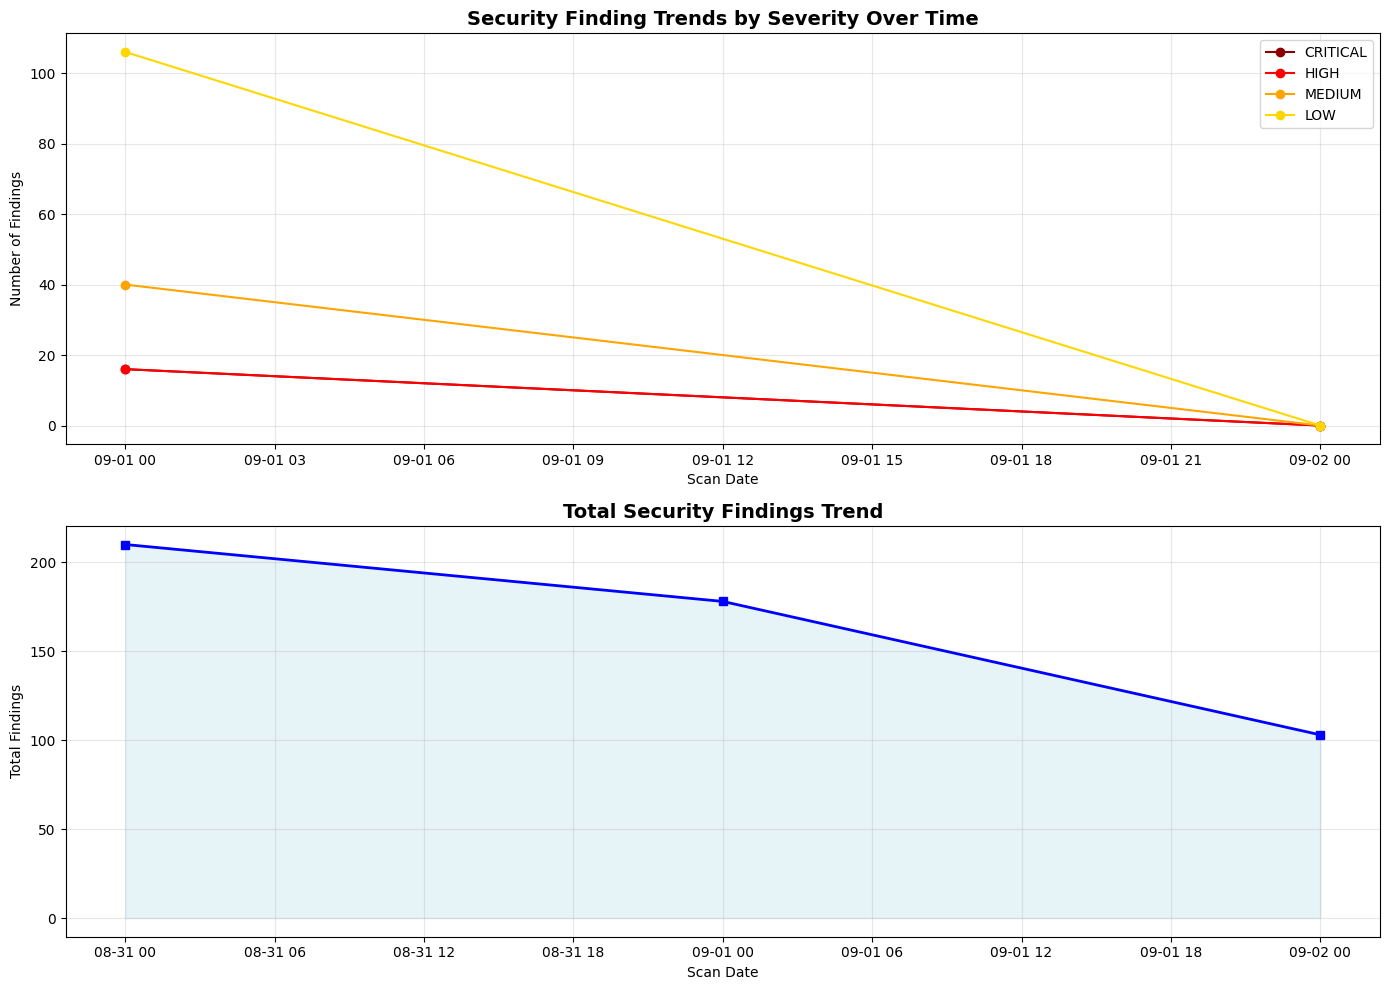


📊 Trend Analysis:
   Latest scan (2025-09-02): 103 findings
   Previous scan (2025-09-01): 178 findings
   Change: -75 findings (-42.1%)
   Security posture: improving


In [13]:
if len(df_helm) > 0 and df_helm['scan_date'].nunique() > 1:
    # Time-based analysis
    daily_trends = df_helm.groupby(['scan_date', 'severity']).size().unstack(fill_value=0)
    
    # Ensure all severity levels are present
    for severity in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'INFO']:
        if severity not in daily_trends.columns:
            daily_trends[severity] = 0
    
    print("📊 Historical Security Trends for Helm Charts:")
    print(daily_trends.tail().to_string())
    
    # Visualize trends
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Severity trends over time
    severity_colors = {'CRITICAL': 'darkred', 'HIGH': 'red', 'MEDIUM': 'orange', 'LOW': 'gold', 'INFO': 'lightblue'}
    available_severities = [s for s in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'INFO'] if s in daily_trends.columns]
    
    for severity in available_severities:
        if daily_trends[severity].sum() > 0:  # Only plot if there's data
            ax1.plot(daily_trends.index, daily_trends[severity], 
                    marker='o', label=severity, color=severity_colors.get(severity, 'gray'))
    
    ax1.set_title('Security Finding Trends by Severity Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Scan Date')
    ax1.set_ylabel('Number of Findings')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Total findings trend
    daily_totals = df_helm.groupby('scan_date').size()
    ax2.plot(daily_totals.index, daily_totals.values, marker='s', color='blue', linewidth=2)
    ax2.fill_between(daily_totals.index, daily_totals.values, alpha=0.3, color='lightblue')
    ax2.set_title('Total Security Findings Trend', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Scan Date')
    ax2.set_ylabel('Total Findings')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate trend metrics
    latest_scan = daily_totals.index.max()
    previous_scan = daily_totals.index[-2] if len(daily_totals) > 1 else latest_scan
    
    latest_count = daily_totals[latest_scan]
    previous_count = daily_totals[previous_scan] if len(daily_totals) > 1 else latest_count
    
    trend_change = latest_count - previous_count
    trend_pct = (trend_change / previous_count * 100) if previous_count > 0 else 0
    
    print("\n📊 Trend Analysis:")
    print(f"   Latest scan ({latest_scan}): {latest_count} findings")
    if len(daily_totals) > 1:
        print(f"   Previous scan ({previous_scan}): {previous_count} findings")
        print(f"   Change: {trend_change:+d} findings ({trend_pct:+.1f}%)")
        
        trend_direction = "improving" if trend_change < 0 else "worsening" if trend_change > 0 else "stable"
        print(f"   Security posture: {trend_direction}")

elif len(df_helm) > 0:
    print("📊 Single scan date found - no trend analysis available")
else:
    print("⚠️  No helm chart data available for trend analysis")

## 6. Helm Chart Security Recommendations

Generate actionable security recommendations based on analysis results.

In [14]:
if len(df_helm) > 0:
    print("🎯 HELM CHART SECURITY RECOMMENDATIONS")
    print("="*60)
    
    # Priority 1: Critical/High severity issues
    high_severity_charts = security_overview[
        (security_overview['critical'] > 0) | (security_overview['high'] > 0)
    ].sort_values('risk_score', ascending=False)
    
    if len(high_severity_charts) > 0:
        print("\n🔴 PRIORITY 1: Charts with Critical/High Severity Issues")
        for chart, row in high_severity_charts.head(5).iterrows():
            critical = int(row['critical'])
            high = int(row['high'])
            risk = row['risk_score']
            print(f"   • {chart}: {critical} critical, {high} high (risk: {risk:.1f})")
    
    # Priority 2: Most widespread issues
    if 'widespread_issues' in locals() and len(widespread_issues) > 0:
        print("\n🟠 PRIORITY 2: Most Widespread Security Issues")
        for (check, kind), row in widespread_issues.head(5).iterrows():
            charts = int(row['charts_affected'])
            instances = int(row['total_instances'])
            print(f"   • {check} ({kind}): Fix in {charts} charts ({instances} instances)")
    
    # Priority 3: Scanner coverage gaps
    low_coverage_charts = security_overview[security_overview['scanners'] < 3]
    if len(low_coverage_charts) > 0:
        print("\n🟡 PRIORITY 3: Charts with Low Scanner Coverage")
        for chart, row in low_coverage_charts.head(5).iterrows():
            scanners = int(row['scanners'])
            findings = int(row['total_findings'])
            print(f"   • {chart}: Only {scanners} scanners used ({findings} findings found)")
        print("   → Recommendation: Scan with additional security tools for comprehensive coverage")
    
    # Best practices
    print("\n🌟 BEST PRACTICES FOR HELM CHART SECURITY:")
    print("   • Use multiple scanners for comprehensive security assessment")
    print("   • Prioritize fixing critical and high severity issues first")
    print("   • Address widespread issues that affect multiple charts")
    print("   • Implement security scanning in CI/CD pipelines")
    print("   • Regular security reviews for charts with high resource diversity")
    print("   • Monitor security trends over time to track improvements")
    
    # Scanner recommendations
    if 'effectiveness_sorted' in locals():
        top_scanner = effectiveness_sorted.index[0]
        print("\n🔍 RECOMMENDED SCANNER FOR HELM CHARTS:")
        print(f"   Primary: {top_scanner} (highest overall effectiveness score)")
        if len(effectiveness_sorted) > 1:
            secondary_scanner = effectiveness_sorted.index[1]
            print(f"   Secondary: {secondary_scanner} (for comprehensive coverage)")
    
    # Export recommendations
    output_dir = Path('../data/helm_analysis')
    output_dir.mkdir(exist_ok=True)
    
    # Save analysis results
    security_overview.to_csv(output_dir / 'helm_security_overview.csv')
    if 'widespread_issues' in locals():
        widespread_issues.to_csv(output_dir / 'common_security_issues.csv')
    if 'scanner_performance' in locals():
        scanner_performance.to_csv(output_dir / 'scanner_performance_helm.csv')
    
    print(f"\n💾 Analysis results saved to: {output_dir}")
    
else:
    print("⚠️  No helm chart data available for generating recommendations")
    print("\nTo get started:")
    print("1. Run: poetry run cli scan <scanner> -f helm-charts")
    print("2. Execute this notebook again for comprehensive analysis")

🎯 HELM CHART SECURITY RECOMMENDATIONS

🔴 PRIORITY 1: Charts with Critical/High Severity Issues
   • ingress-nginx: 5 critical, 4 high (risk: 1.9)
   • cert-manager: 5 critical, 7 high (risk: 1.7)
   • kube-prometheus-stack: 6 critical, 5 high (risk: 1.5)

🟠 PRIORITY 2: Most Widespread Security Issues
   • The default namespace should not be used (ConfigMap): Fix in 3 charts (33 instances)
   • The default namespace should not be used (ServiceAccount): Fix in 3 charts (14 instances)
   • Role or ClusterRole with dangerous permissions (ClusterRole): Fix in 3 charts (11 instances)
   • The default namespace should not be used (Service): Fix in 3 charts (11 instances)
   • Container could be running with outdated image (Deployment): Fix in 3 charts (9 instances)

🌟 BEST PRACTICES FOR HELM CHART SECURITY:
   • Use multiple scanners for comprehensive security assessment
   • Prioritize fixing critical and high severity issues first
   • Address widespread issues that affect multiple charts
 

## Summary

This comprehensive helm chart security analysis provides:

### Key Insights:
- **Chart-specific risk assessment** with severity-weighted scoring
- **Scanner effectiveness comparison** for helm chart security scanning
- **Common security patterns** identification across helm deployments
- **Historical trend analysis** for security posture monitoring
- **Actionable recommendations** prioritized by risk and impact

### Practical Applications:
- **Risk-based prioritization** for security remediation efforts
- **Scanner selection** based on helm chart effectiveness metrics
- **Security pattern recognition** to prevent recurring issues
- **Trend monitoring** for continuous security improvement
- **Resource optimization** by focusing on high-impact security fixes

This analysis enables data-driven security decisions for helm chart deployments and helps establish effective security scanning strategies for kubernetes helm-based infrastructure.